**Univariate Time Series Forecasting with NimbusML**

In [65]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
from nimbusml import Pipeline
from nimbusml.timeseries import SsaForecaster
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

ImportError: cannot import name 'mean_absolute_percentage_error'

In [3]:
# Load image summary data from github
url_to_csv = "https://raw.githubusercontent.com/mstfbl/NimbusML-Samples/Issue-22/datasets/max_planck_weather_time_series_dataset.csv"
df_train = pd.read_csv(filepath_or_buffer=url_to_csv, sep = ",",)

In [95]:
# Set constant random seed
np.random.seed(13)

Let's look at our data.

In [5]:
df_train.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [7]:
TRAIN_SPLIT = 300000

**Single-step prediction**

In [8]:
data_univariate = df_train['T (degC)']
data_univariate.index = df_train['Date Time']
data_univariate.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002CF2125AA58>],
      dtype=object)

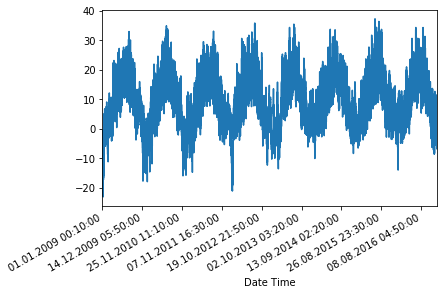

In [9]:
data_univariate.plot(subplots=True)

In [10]:
data_univariate = data_univariate.values
data_univariate_mean = data_univariate[:TRAIN_SPLIT].mean()
data_univariate_std = data_univariate[:TRAIN_SPLIT].std()
data_univariate = (data_univariate-data_univariate_mean)/data_univariate_std

In [11]:
univariate_past_history = 21
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(data_univariate, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(data_univariate, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [12]:
print(len(x_val_uni))

120530


In [13]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]
 [-2.10418486]]

 Target temperature to predict
-2.0949220845536356


In [14]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [15]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\mubal\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

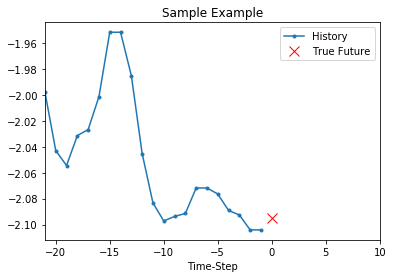

In [16]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [17]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\mubal\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

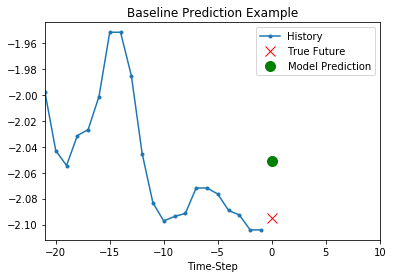

In [18]:
#print(x_train_uni[0])
#print(y_train_uni[0])
#print(baseline(x_train_uni[0]))
#print(x_train_uni.shape[-2:])
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

In [91]:
x_val_uni_list = [x[0] for x in x_val_uni[0].tolist()]
X_val_ssa = pd.Series(x_val_uni_list, name="T (degC)")
#print(X_val_ssa)
#print(len(x_train_uni[0])) #almost 2100 days worth of data
x_train_uni_list_big = x_train_uni.flatten()
X_train_ssa_big = pd.Series(x_train_uni_list_big, name="T (degC)")
#print(X_train_ssa_big.head())

In [20]:
#seasonality_size = 52560 # 365 (length of season in days) * 144 (with 10 minute interval samples, 144 samples in one day)
#training_seasons = 749950 #roughly 8 seasons displayed in entire dataset, so len(X_train_ssa_big) / 8
#training_size = seasonality_size * training_seasons
#pipeline = Pipeline([
#    SsaForecaster(series_length= 449996, #arbitrary for now
#                  train_size= training_size,
#                  window_size= seasonality_size + 1,
#                  horizon=3,
#                  columns={'T (degC)_fc': 'T (degC)'})
#])

In [21]:
# Parameters to be tuned later
pipeline = Pipeline([
    SsaForecaster(series_length=6,
                  train_size=20,
                  window_size=3,
                  horizon=1,
                  columns={'T (degC)_fc': 'T (degC)'})
])

In [22]:
print(len(X_train_ssa_big))
pipeline.fit(X_train_ssa_big)
print(X_train_ssa_big)

6299559
Elapsed time: 00:00:00.7929808
0         -1.997663
1         -2.042819
2         -2.054397
3         -2.031241
4         -2.026609
             ...   
6299554    0.652649
6299555    0.652649
6299556    0.648017
6299557    0.644544
6299558    0.644544
Name: T (degC), Length: 6299559, dtype: float64


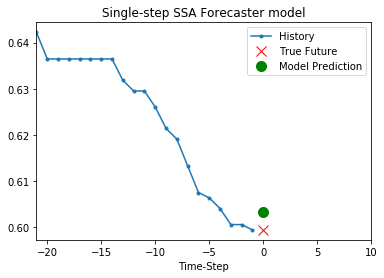

In [23]:
predicted_val_uni = pipeline.transform(X_val_ssa)
predicted_val = predicted_val_uni['T (degC)_fc.0'][20]
plot = show_plot([x_val_uni[0], y_val_uni[0], predicted_val], 0, 'Single-step SSA Forecaster model')
plot.show()

In [24]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

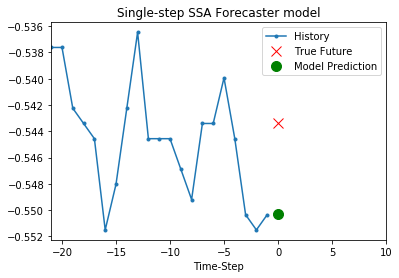

Absolute Percentage Error: 1.27260411620107%%


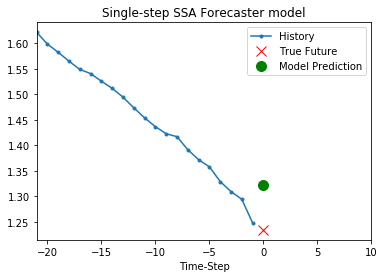

Absolute Percentage Error: 7.1329304004391165%%


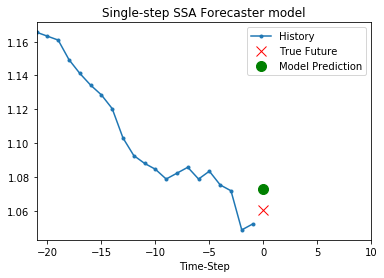

Absolute Percentage Error: 1.1988353676808947%%


In [107]:
random_is = np.random.randint(len(x_val_uni), size=3)
for i in random_is:
    # Predicting
    x_val_uni_list = [x[0] for x in x_val_uni[i].tolist()]
    X_val_ssa = pd.Series(x_val_uni_list, name="T (degC)")
    predicted_val_uni = pipeline.transform(X_val_ssa)
    predicted_val = predicted_val_uni['T (degC)_fc.0'][19]
    plot = show_plot([x_val_uni[i], y_val_uni[i], predicted_val], 0, 'Single-step SSA Forecaster model')
    plot.show()
    # Performace
    # mean absolute percentage error = mean(((y_true - y_pred) / y_true)) * 100)
    abe = abs(((y_val_uni[i] - predicted_val) / y_val_uni[i]) * 100)
    print("Absolute Percentage Error: {}%%".format(abe))

In [113]:
#Performance testing for 1000 random single-step SSA Forecasts
num_predictions = 1000
random_is = np.random.randint(len(x_val_uni), size=num_predictions)
mapes = [-1 for _ in range(num_predictions)]
for c, i in enumerate(random_is):
    # Predicting
    x_val_uni_list = [x[0] for x in x_val_uni[i].tolist()]
    X_val_ssa = pd.Series(x_val_uni_list, name="T (degC)")
    predicted_val_uni = pipeline.transform(X_val_ssa)
    predicted_val = predicted_val_uni['T (degC)_fc.0'][19]
    # Performace
    # mean absolute percentage error = mean(((y_true - y_pred) / y_true)) * 100)
    mapes[c] = abs(y_val_uni[i] - predicted_val) / abs(y_val_uni[i]) * 100
print("Mean absolute percentage error of {} samples for single-Step SSA forecasting: {}%.".format(len(mapes), np.mean(mapes)))

Mean absolute percentage error of 1000 samples for single-Step SSA forecasting: 27.147758619081042%.


In [149]:
#Validating on the entire validation dataset of size 119759 data points, 
print("Size of training dataset for SSA Single-Step Forecasting on NimbusML: {}.".format(len(x_train_uni)))
print("Size of validation dataset for SSA Single-Step Forecasting on NimbusML: {}.".format(len(x_val_uni)))
mapes_total = 0
iter_count = 0
for i in range(len(x_val_uni)):
    # Predicting
    x_val_uni_list = [x[0] for x in x_val_uni[i].tolist()]
    X_val_ssa = pd.Series(x_val_uni_list, name="T (degC)")
    predicted_val_uni = pipeline.transform(X_val_ssa)
    predicted_val = predicted_val_uni['T (degC)_fc.0'][19]
    # Performace
    # mean absolute percentage error = mean(((y_true - y_pred) / y_true)) * 100)
    mapes_total += abs(y_val_uni[i] - predicted_val) / abs(y_val_uni[i])
    iter_count += 1
    if iter_count % 1000 == 0:
        print("Iteration {}/{} - Current MAPE: {}%".format(iter_count, len(x_val_uni), mapes_total*100/iter_count))
print("Mean absolute percentage error of {} samples for single-Step SSA forecasting: {}%.".format(len(mapes), mapes_total*100/iter_count))

Size of training dataset for SSA Single-Step Forecasting on NimbusML: 299979.
Size of validation dataset for SSA Single-Step Forecasting on NimbusML: 120530.
Iteration 1000/120530 - Current MAPE: 5.5020905375888844%
Iteration 2000/120530 - Current MAPE: 23.02230872529188%
Iteration 3000/120530 - Current MAPE: 23.744488162315687%
Iteration 4000/120530 - Current MAPE: 25.9577627901837%
Iteration 5000/120530 - Current MAPE: 24.79275975999554%
Iteration 6000/120530 - Current MAPE: 30.697846708497803%
Iteration 7000/120530 - Current MAPE: 34.89977666227966%
Iteration 8000/120530 - Current MAPE: 38.08278120541613%
Iteration 9000/120530 - Current MAPE: 38.047696378502856%
Iteration 10000/120530 - Current MAPE: 38.24930560568665%
Iteration 11000/120530 - Current MAPE: 36.825994005179666%
Iteration 12000/120530 - Current MAPE: 33.859702647318954%
Iteration 13000/120530 - Current MAPE: 32.07822675322207%
Iteration 14000/120530 - Current MAPE: 31.60786340161249%
Iteration 15000/120530 - Current M

KeyboardInterrupt: 

**Multi-step prediction**

In [26]:
features_considered = ['T (degC)']

In [27]:
features = df_train[features_considered]
features.index = df_train['Date Time']
features.head()

,T (degC)
Date Time,
01.01.2009 00:10:00,-8.02
01.01.2009 00:20:00,-8.41
01.01.2009 00:30:00,-8.51
01.01.2009 00:40:00,-8.31
01.01.2009 00:50:00,-8.27


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002CF2AC71E10>],
      dtype=object)

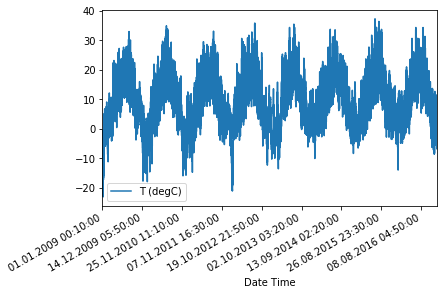

In [28]:
features.plot(subplots=True)

In [29]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [30]:
dataset = (dataset-data_mean)/data_std

In [35]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [36]:
past_history = 720
future_target = 72
STEP = 6
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [37]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [38]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

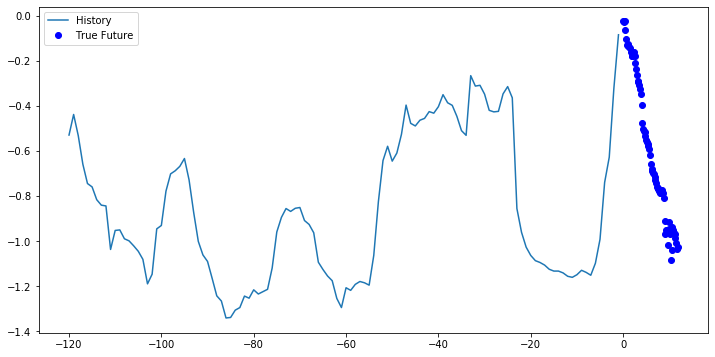

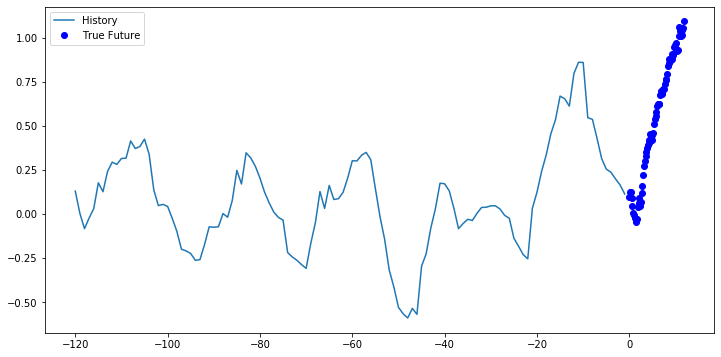

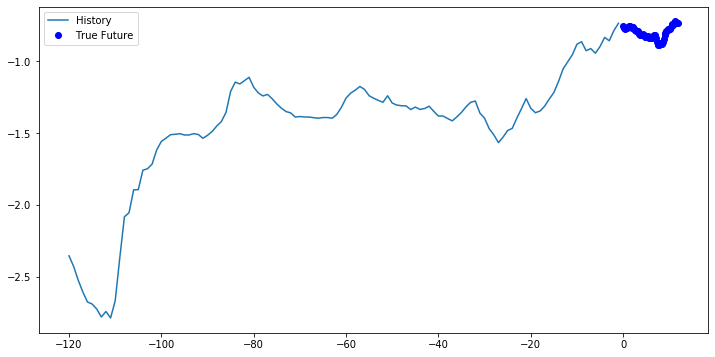

In [133]:
random_is = np.random.randint(len(x_val_uni), size=3)
for i in random_is:
    multi_step_plot(x_train_multi[i], y_train_multi[i], np.array([0]))

In [69]:
X_train_multi_ssa_big = pd.Series(x_train_multi.flatten(), name="T (degC)")

In [41]:
given_series_length = 90
seasonality_size = 25
training_seasons = 4
training_size = seasonality_size * training_seasons
pipeline_multi = Pipeline([
    SsaForecaster(series_length= given_series_length,
                  train_size= training_size,
                  window_size= seasonality_size + 1,
                  horizon=72,
                  columns={'T (degC)_fc': 'T (degC)'})
])

In [42]:
pipeline_multi.fit(X_train_multi_ssa_big)

Elapsed time: 00:00:00.6013943


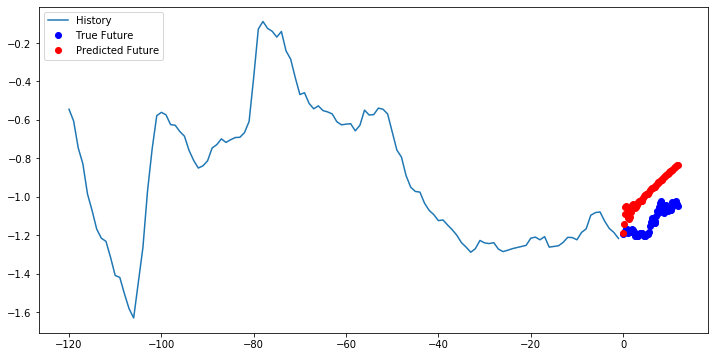

Bias/Mean Forecast Error: -0.159451
Mean Absolute Error: 0.159451
Mean Squared Error: 0.027245
Root Mean Squared Error: 0.165061
Mean Absolute Percentage Error: 14.229059%


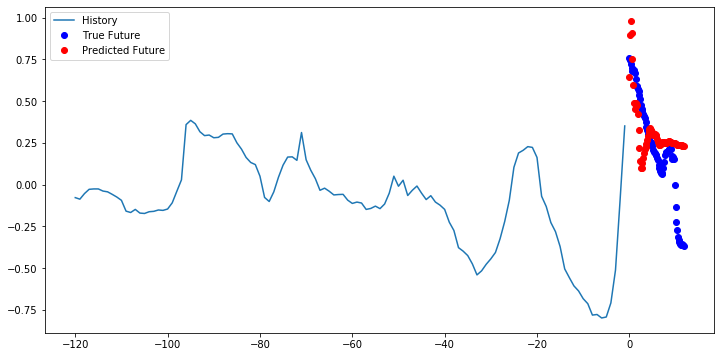

Bias/Mean Forecast Error: -0.093157
Mean Absolute Error: 0.207104
Mean Squared Error: 0.073716
Root Mean Squared Error: 0.271506
Mean Absolute Percentage Error: 303.805340%


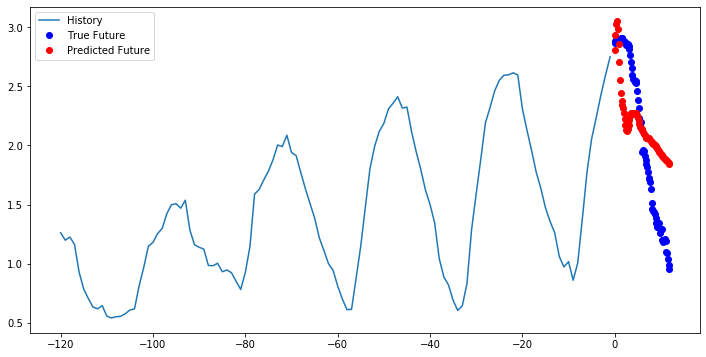

Bias/Mean Forecast Error: -0.110750
Mean Absolute Error: 0.437331
Mean Squared Error: 0.252961
Root Mean Squared Error: 0.502953
Mean Absolute Percentage Error: 26.959915%


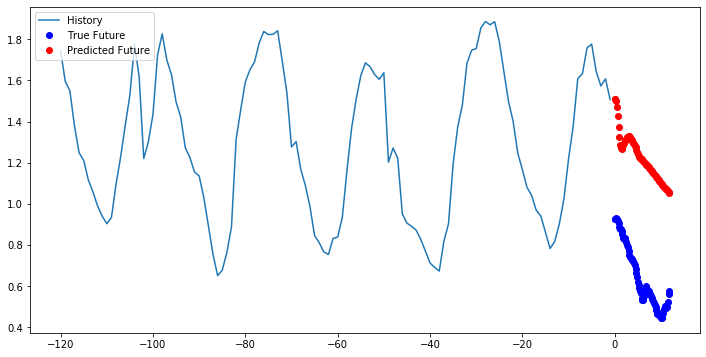

Bias/Mean Forecast Error: -0.579244
Mean Absolute Error: 0.579244
Mean Squared Error: 0.340510
Root Mean Squared Error: 0.583532
Mean Absolute Percentage Error: 96.684775%


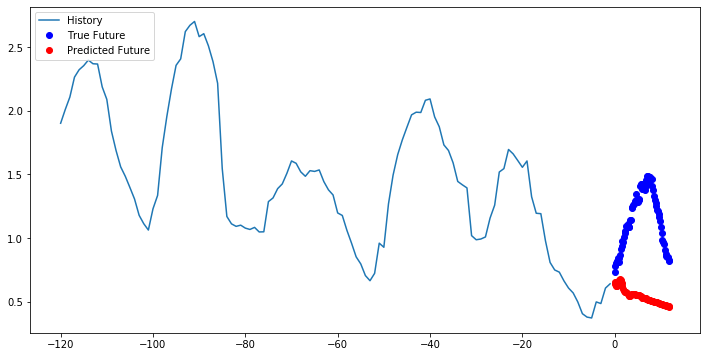

Bias/Mean Forecast Error: 0.613680
Mean Absolute Error: 0.613680
Mean Squared Error: 0.438042
Root Mean Squared Error: 0.661848
Mean Absolute Percentage Error: 50.845437%


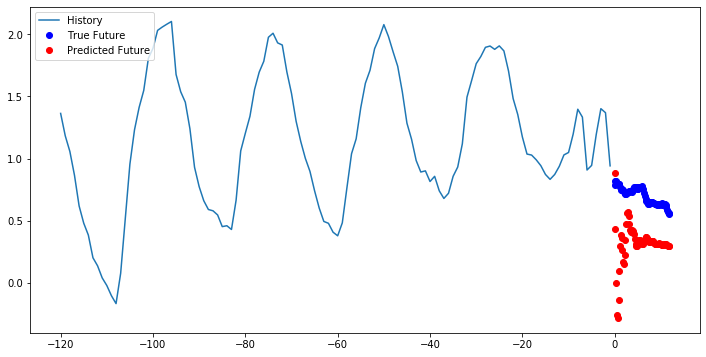

Bias/Mean Forecast Error: 0.383454
Mean Absolute Error: 0.386220
Mean Squared Error: 0.179214
Root Mean Squared Error: 0.423337
Mean Absolute Percentage Error: 54.453108%


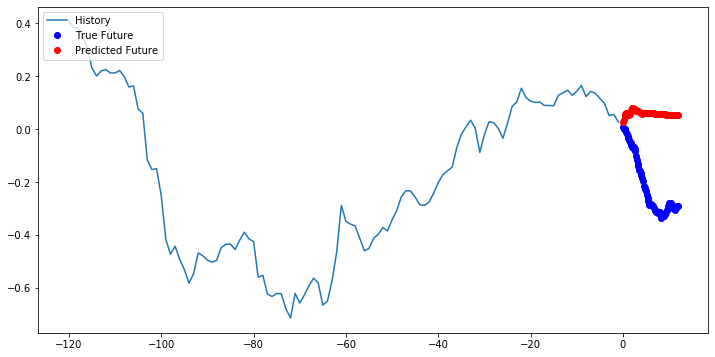

Bias/Mean Forecast Error: -0.271599
Mean Absolute Error: 0.271599
Mean Squared Error: 0.086028
Root Mean Squared Error: 0.293305
Mean Absolute Percentage Error: 303.867557%


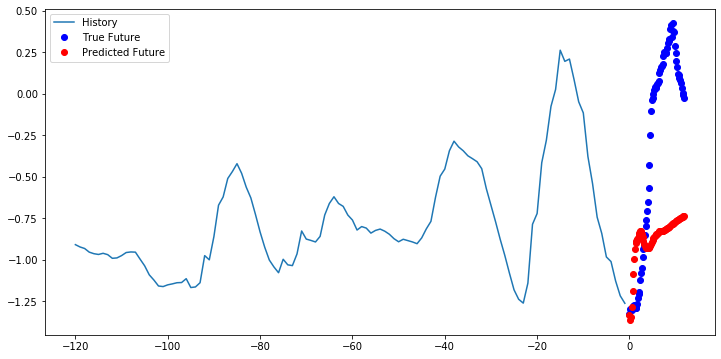

Bias/Mean Forecast Error: 0.567410
Mean Absolute Error: 0.682287
Mean Squared Error: 0.612860
Root Mean Squared Error: 0.782854
Mean Absolute Percentage Error: 4254.553403%


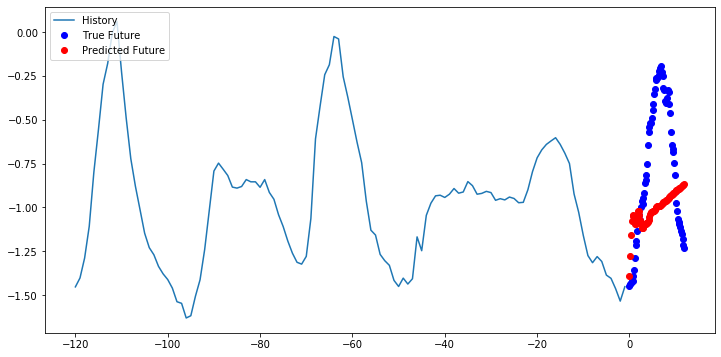

Bias/Mean Forecast Error: 0.237110
Mean Absolute Error: 0.375500
Mean Squared Error: 0.197317
Root Mean Squared Error: 0.444203
Mean Absolute Percentage Error: 94.566113%


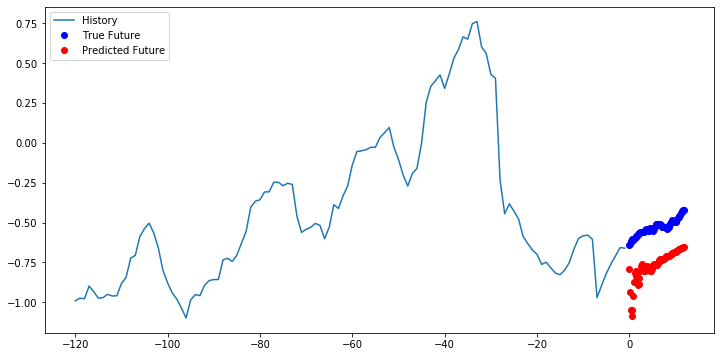

Bias/Mean Forecast Error: 0.235208
Mean Absolute Error: 0.235208
Mean Squared Error: 0.058559
Root Mean Squared Error: 0.241990
Mean Absolute Percentage Error: 44.315251%


In [130]:
random_is = np.random.randint(len(x_val_multi), size=10)
for i in random_is:
    # Predicting
    random_i = random.randint(0, len(x_val_multi))
    x_val_multi_list = [x[0] for x in x_val_multi[i].tolist()]
    X_val_multi_ssa = pd.Series(x_val_multi_list, name="T (degC)")
    transformed_horizons = pipeline_multi.transform(X_val_multi_ssa).drop("T (degC)", 1)
    predicted_vals_multi = [0 for _ in range(72)]
    count = 0
    for (_, columnData) in transformed_horizons.iteritems():
        predicted_vals_multi[count] = columnData.values[119]
        count += 1
    multi_step_plot(x_val_multi[i], y_val_multi[i], np.asarray(predicted_vals_multi))
    # Performance
    # forecast_error = expected_value - predicted_value
    # bias = mean_forecast_error = mean(forecast_error)
    # mean_absolute_error = mean( abs(forecast_error) )
    # mean_squared_error = mean_squared_error = mean(forecast_error^2)
    # rmse = sqrt(mean_squared_error)
    # mean absolute percentage error = mean(((y_true - y_pred) / y_true)) * 100)
    predicted_values = np.asarray(predicted_vals_multi)
    expected_values = np.asarray(y_val_multi[i])
    forecast_errors = [expected_values[j]-predicted_values[j] for j in range(len(expected_values))]
    bias = sum(forecast_errors) /len(expected_values)
    print('Bias/Mean Forecast Error: %f' % bias)
    mae = mean_absolute_error(expected_values, predicted_values)
    print('Mean Absolute Error: %f' % mae)
    mse = mean_squared_error(expected_values, predicted_values)
    print('Mean Squared Error: %f' % mse)
    rmse = sqrt(mse)
    print('Root Mean Squared Error: %f' % rmse)
    mape = np.mean(abs(expected_values - predicted_values) / abs(expected_values)) * 100
    print('Mean Absolute Percentage Error: %f%%' % mape)

In [127]:
#100 random predictions
print(len((x_val_multi)))
num_predictions = 100
random_is = np.random.randint(len(x_val_multi), size=num_predictions)
mapes = [-1 for _ in range(num_predictions)]
for c, i in enumerate(random_is):
    # Predicting
    #random_i = random.randint(0, len(x_val_multi))
    random_i = c
    x_val_multi_list = [x[0] for x in x_val_multi[i].tolist()]
    X_val_multi_ssa = pd.Series(x_val_multi_list, name="T (degC)")
    transformed_horizons = pipeline_multi.transform(X_val_multi_ssa).drop("T (degC)", 1)
    predicted_vals_multi = [0 for _ in range(72)]
    count = 0
    for (_, columnData) in transformed_horizons.iteritems():
        predicted_vals_multi[count] = columnData.values[119]
        count += 1
    # Performance
    # mean absolute percentage error = mean(((y_true - y_pred) / y_true)) * 100)
    predicted_values = np.asarray(predicted_vals_multi)
    expected_values = np.asarray(y_val_multi[i])
    mape = np.mean(np.abs(abs(expected_values - predicted_values) / abs(expected_values))) * 100
    mapes[c] = abs(y_val_uni[i] - predicted_val) / abs(y_val_uni[i]) * 100
print("Mean absolute percentage error of {} samples for Multi-Step SSA forecasting with NimbusmL: {}%.".format(len(mapes), np.mean(mapes)))

119759
Mean absolute percentage error of 100 samples for Multi-Step SSA forecasting with NimbusmL: 1830.902904207399%.


### Validating Multi-Step SSA Forecasting
The size of x_train_multi is 299280 data points, which corresponds to around 2078 days of weather data.
The size of x_val_multi is 119759 data points, which corresponds to around 831 days of weather data.

In [144]:
#Validating on the entire validation dataset of size 119759 data points, 
print("Size of training dataset for SSA Multi-Step Forecasting on NimbusML: {}.".format(len(x_train_multi)))
print("Size of validation dataset for SSA Multi-Step Forecasting on NimbusML: {}.".format(len(x_val_multi)))
#num_predictions = 100
#random_is = np.random.randint(len(x_val_multi), size=num_predictions)
mapesTotal = 0
iter_count = 0
for i in range(len(x_val_multi)):
    # Predicting
    #random_i = random.randint(0, len(x_val_multi))
    x_val_multi_list = [x[0] for x in x_val_multi[i].tolist()]
    X_val_multi_ssa = pd.Series(x_val_multi_list, name="T (degC)")
    transformed_horizons = pipeline_multi.transform(X_val_multi_ssa).drop("T (degC)", 1)
    predicted_vals_multi = [0 for _ in range(72)]
    count = 0
    for (_, columnData) in transformed_horizons.iteritems():
        predicted_vals_multi[count] = columnData.values[119]
        count += 1
    # Performance
    # mean absolute percentage error = mean(((y_true - y_pred) / y_true)) * 100)
    #predicted_values = np.asarray(predicted_vals_multi)
    #expected_values = np.asarray(y_val_multi[i])
    mape_raw = np.mean(np.abs(abs(y_val_multi[i] - predicted_vals_multi) / abs(y_val_multi[i])))
    mapesTotal += mape_raw
    iter_count += 1
    if iter_count % 1000 == 0:
        print("Iteration {}/{} - Current MAPE: {}%".format(iter_count, len(x_val_multi), mapesTotal*100/iter_count))
    final_mape = mapesTotal / iter_count
print("Mean absolute percentage error of {} samples for Multi-Step SSA forecasting with NimbusML: {}%.".format(iter_count, mapesTotal*100/iter_count))

Size of training dataset for SSA Multi-Step Forecasting on NimbusML: 299280.
Size of validation dataset for SSA Multi-Step Forecasting on NimbusML: 119759.
Iteration 1000/119759 - Current MAPE: 416.5008926937724%
Iteration 2000/119759 - Current MAPE: 281.4678089536982%
Iteration 3000/119759 - Current MAPE: 274.20470866458004%
Iteration 4000/119759 - Current MAPE: 249.23166637789132%
Iteration 5000/119759 - Current MAPE: 232.11311806236253%
Iteration 6000/119759 - Current MAPE: 234.22302251857357%
Iteration 7000/119759 - Current MAPE: 249.6854924063248%
Iteration 8000/119759 - Current MAPE: 241.94336218610437%
Iteration 9000/119759 - Current MAPE: 237.26236724631033%
Iteration 10000/119759 - Current MAPE: 238.71896276084823%
Iteration 11000/119759 - Current MAPE: 218.62218836542814%
Iteration 12000/119759 - Current MAPE: 201.7448100907916%
Iteration 13000/119759 - Current MAPE: 195.63357579889524%
Iteration 14000/119759 - Current MAPE: 203.6112851328513%
Iteration 15000/119759 - Current